In [1]:
import pandas as pd
from datasets import Dataset, load_metric
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, get_scheduler
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import dill

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
df_train = pd.read_csv('./train.tsv', sep='\t', names=['text', 'Domain'])
df_train.head()

,text,Domain
0,the quality of being beneficial and generally ...,Philosophy and psychology
1,insure again by transferring to another insura...,"Business, economics, and finance"
2,foolish gibberish,Language and linguistics
3,the property of being a relatively small amoun...,Mathematics
4,an arrangement of a piece of music for perform...,Music


In [4]:
df_test = pd.read_csv('./test.tsv', sep='\t', names=['text', 'Domain'])
df_test.head()

,text,Domain
0,(physics) statistical law obeyed by a system o...,Physics and astronomy
1,(physics) the process in which incident radiat...,Physics and astronomy
2,(physics) the exponential return of a system t...,Physics and astronomy
3,(physics) a coefficient that expresses how muc...,Physics and astronomy
4,(physics) the point of minimum displacement in...,Physics and astronomy


In [5]:
# df_train.Domain.value_counts().plot(kind='pie', figsize=(8,8), title="Train partition", ylabel='')

In [6]:
# df_test.Domain.value_counts().plot(kind='pie', figsize=(8,8), title="Test partition", ylabel='')

In [7]:
label2id = {}

def encode_domain(x):
    if x not in label2id.keys():
        label2id[x]=len(label2id)
    return label2id[x]

df_train['labels'] = df_train['Domain'].apply(lambda x: encode_domain(x))
assert df_train['labels'].max() == 33, "The maximum encoded category should be 33" #Hay 34 clases en total
df_train = df_train.drop(columns='Domain')
df_train.head()

,text,labels
0,the quality of being beneficial and generally ...,0
1,insure again by transferring to another insura...,1
2,foolish gibberish,2
3,the property of being a relatively small amoun...,3
4,an arrangement of a piece of music for perform...,4


In [8]:
df_test['labels'] = df_test['Domain'].apply(lambda x: encode_domain(x))
assert df_test['labels'].max() == 33, "The maximum encoded category should be 33" #Hay 34 clases en total
df_test = df_test.drop(columns='Domain')
df_test.head()

,text,labels
0,(physics) statistical law obeyed by a system o...,14
1,(physics) the process in which incident radiat...,14
2,(physics) the exponential return of a system t...,14
3,(physics) a coefficient that expresses how muc...,14
4,(physics) the point of minimum displacement in...,14


In [9]:
id2label = {index: label for label, index in label2id.items()}
print(id2label)

{0: 'Philosophy and psychology', 1: 'Business, economics, and finance', 2: 'Language and linguistics', 3: 'Mathematics', 4: 'Music', 5: 'Animals', 6: 'Warfare and defense', 7: 'Literature and theatre', 8: 'Numismatics and currencies', 9: 'Religion, mysticism and mythology', 10: 'Biology', 11: 'Media', 12: 'Geography and places', 13: 'Education', 14: 'Physics and astronomy', 15: 'Health and medicine', 16: 'Heraldry, honors, and vexillology', 17: 'Engineering and technology', 18: 'Chemistry and mineralogy', 19: 'Law and crime', 20: 'Computing', 21: 'Art, architecture, and archaeology', 22: 'Food and drink', 23: 'Textile and clothing', 24: 'Sport and recreation', 25: 'Transport and travel', 26: 'Geology and geophysics', 27: 'Farming', 28: 'Politics and government', 29: 'Meteorology', 30: 'Royalty and nobility', 31: 'Culture and society', 32: 'Games and video games', 33: 'History'}


Vamos a crear la partición de validación y ya podemos crear los tres Datasets

In [10]:
train_size = 0.85
train=df_train.sample(frac=train_size,random_state=200).reset_index(drop=True)
valid=df_train.drop(train.index).reset_index(drop=True)
train_dataset = Dataset.from_pandas(train)
valid_dataset = Dataset.from_pandas(valid)
test_dataset = Dataset.from_pandas(df_test)

## Entrenamiento

In [11]:
model_ckpt='distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [12]:
def preprocess_function(examples):
    return tokenizer(examples["text"],truncation=True, max_length = 512)

In [13]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_valid = valid_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_valid = tokenized_valid.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])

tokenized_train.set_format("torch")
tokenized_valid.set_format("torch")
tokenized_test.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_train, batch_size=8, shuffle=True, collate_fn=data_collator)
valid_dataloader = DataLoader(tokenized_valid, batch_size=64, shuffle=False, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_valid, batch_size=64, shuffle=False, collate_fn=data_collator)

Map:   0%|          | 0/10072 [00:00<?, ? examples/s]

Map:   0%|          | 0/1777 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

In [38]:
num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [39]:

    
progress_bar = tqdm(range(num_training_steps))
train_losses=[]
valid_losses=[]

for epoch in range(num_epochs):    
    train_loss=0.0
    model.train()
    if epoch ==3:
        torch.save(model, "./Pretrained/distilbertEpoch4Tasa2e-5")
    for batch_num, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        train_loss += loss.item()

        if (batch_num + 1) % 200 == 0:
            model.eval()  # Establecer el modelo en modo de evaluación
            val_loss = 0.0

            with torch.no_grad():
                for val_batch in valid_dataloader:
                    val_batch = {k: v.to(device) for k, v in val_batch.items()}
                    val_outputs = model(**val_batch)
                    val_loss += val_outputs.loss.item()

            # Calcular la pérdida de validación promedio
            avg_val_loss = val_loss / len(valid_dataloader)

            # Guardar los valores de pérdida
            train_losses.append(train_loss / 200)
            valid_losses.append(avg_val_loss)

            print(f"Epoch {epoch + 1}, Iteration {batch_num + 1}, Training Loss: {train_loss / 200:.4f}, Validation Loss: {avg_val_loss:.4f}")
            train_loss=0.0



  0%|          | 0/12590 [00:00<?, ?it/s]

Epoch 1, Iteration 200, Training Loss: 2.4865, Validation Loss: 1.7280
Epoch 1, Iteration 400, Training Loss: 1.3248, Validation Loss: 1.0765
Epoch 1, Iteration 600, Training Loss: 1.0132, Validation Loss: 0.8097
Epoch 1, Iteration 800, Training Loss: 0.7989, Validation Loss: 0.6800
Epoch 1, Iteration 1000, Training Loss: 0.6715, Validation Loss: 0.5629
Epoch 1, Iteration 1200, Training Loss: 0.6581, Validation Loss: 0.4977
Epoch 2, Iteration 200, Training Loss: 0.4176, Validation Loss: 0.4264
Epoch 2, Iteration 400, Training Loss: 0.3924, Validation Loss: 0.4006
Epoch 2, Iteration 600, Training Loss: 0.4115, Validation Loss: 0.3550
Epoch 2, Iteration 800, Training Loss: 0.3841, Validation Loss: 0.3237
Epoch 2, Iteration 1000, Training Loss: 0.3467, Validation Loss: 0.3179
Epoch 2, Iteration 1200, Training Loss: 0.3738, Validation Loss: 0.2650
Epoch 3, Iteration 200, Training Loss: 0.2395, Validation Loss: 0.2389
Epoch 3, Iteration 400, Training Loss: 0.1777, Validation Loss: 0.2202
Ep

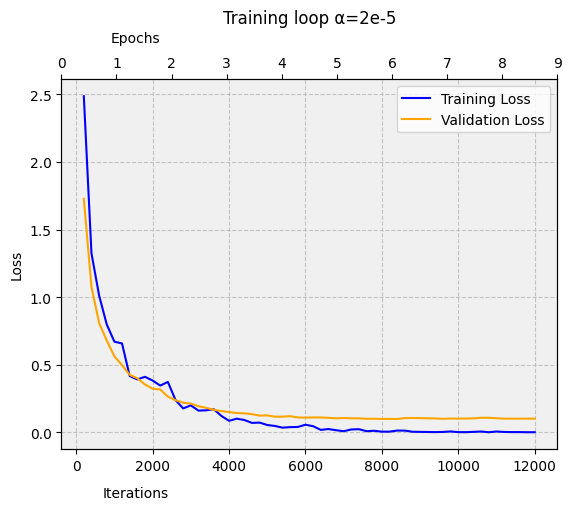

In [42]:
iterations_x = np.arange(1, len(train_losses) + 1) * 200  # Crea un array de valores para cada 200 iteraciones

epochs_x = np.arange(0, num_epochs)  # Crea un array de valores para las épocas

fig, ax1 = plt.subplots()

ax1.plot(iterations_x, train_losses, label='Training Loss', color='blue')
ax1.plot(iterations_x, valid_losses, label='Validation Loss', color='orange')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss', color='black')
ax1.legend(loc='upper right')
ax1.xaxis.set_label_coords(0.15, -0.1)

ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_facecolor('#f0f0f0')

# Crear un segundo eje x para las épocas
ax2 = ax1.twiny()
ax2.set_xticks(epochs_x)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss', color='black') 
ax2.xaxis.set_label_coords(0.15, 1.1)
title = ax1.set_title("Training loop α=2e-5")
title.set_y(2)


plt.show()

In [43]:

def compute_metrics(preds, labels):

    # Obtain predicted class labels by finding the column index with the maximum probability

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary

    return {
    'Accuracy': acc,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
    }


In [47]:
model = torch.load("./Pretrained/distilbertEpoch10Tasa2e-5")
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)

print(metrics)

{'Accuracy': 0.9774901519414744, 'F1': 0.9753252912593974, 'Precision': 0.974650529340336, 'Recall': 0.9770221209873713}


In [45]:
torch.save(model, "./Pretrained/distilbertEpoch10Tasa2e-5")

## Probando otros modelos
#### Bert-Base

In [ ]:
model_ckpt='bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
def preprocess_function(examples):
    return tokenizer(examples["text"],truncation=True, max_length = 512)
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_valid = valid_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_valid = tokenized_valid.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])

tokenized_train.set_format("torch")
tokenized_valid.set_format("torch")
tokenized_test.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_train, batch_size=8, shuffle=True, collate_fn=data_collator)
valid_dataloader = DataLoader(tokenized_valid, batch_size=64, shuffle=False, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_valid, batch_size=64, shuffle=False, collate_fn=data_collator)

num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

model.to(device)

    
progress_bar = tqdm(range(num_training_steps))
train_losses=[]
valid_losses=[]

for epoch in range(num_epochs):    
    train_loss=0.0
    model.train()
    for batch_num, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        train_loss += loss.item()

        if (batch_num + 1) % 200 == 0:
            model.eval()  # Establecer el modelo en modo de evaluación
            val_loss = 0.0

            with torch.no_grad():
                for val_batch in valid_dataloader:
                    val_batch = {k: v.to(device) for k, v in val_batch.items()}
                    val_outputs = model(**val_batch)
                    val_loss += val_outputs.loss.item()

            # Calcular la pérdida de validación promedio
            avg_val_loss = val_loss / len(valid_dataloader)

            # Guardar los valores de pérdida
            train_losses.append(train_loss / 200)
            valid_losses.append(avg_val_loss)

            print(f"Epoch {epoch + 1}, Iteration {batch_num + 1}, Training Loss: {train_loss / 200:.4f}, Validation Loss: {avg_val_loss:.4f}")
            train_loss=0.0


iterations_x = np.arange(1, len(train_losses) + 1) * 200  # Crea un array de valores para cada 200 iteraciones

epochs_x = np.arange(0, num_epochs)  # Crea un array de valores para las épocas

fig, ax1 = plt.subplots()

ax1.plot(iterations_x, train_losses, label='Training Loss', color='blue')
ax1.plot(iterations_x, valid_losses, label='Validation Loss', color='orange')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss', color='black')
ax1.legend(loc='upper right')
ax1.xaxis.set_label_coords(0.15, -0.1)

ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_facecolor('#f0f0f0')

# Crear un segundo eje x para las épocas
ax2 = ax1.twiny()
ax2.set_xticks(epochs_x)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss', color='black') 
ax2.xaxis.set_label_coords(0.15, 1.1)

title = ax1.set_title("Training loop α=8e-4")
title.set_y(2)

plt.show()


model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)
print(metrics)

torch.save(model, "./Pretrained/distilbertSuperEntrenado")

#### Roberta

In [ ]:
model_ckpt='roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
def preprocess_function(examples):
    return tokenizer(examples["text"],truncation=True, max_length = 512)
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_valid = valid_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_valid = tokenized_valid.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])

tokenized_train.set_format("torch")
tokenized_valid.set_format("torch")
tokenized_test.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_train, batch_size=8, shuffle=True, collate_fn=data_collator)
valid_dataloader = DataLoader(tokenized_valid, batch_size=64, shuffle=False, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_valid, batch_size=64, shuffle=False, collate_fn=data_collator)

num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

num_epochs = 10 ##Hyperparameter
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

model.to(device)

    
progress_bar = tqdm(range(num_training_steps))
train_losses=[]
valid_losses=[]

for epoch in range(num_epochs):    
    train_loss=0.0
    model.train()
    for batch_num, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        train_loss += loss.item()

        if (batch_num + 1) % 200 == 0:
            model.eval()  # Establecer el modelo en modo de evaluación
            val_loss = 0.0

            with torch.no_grad():
                for val_batch in valid_dataloader:
                    val_batch = {k: v.to(device) for k, v in val_batch.items()}
                    val_outputs = model(**val_batch)
                    val_loss += val_outputs.loss.item()

            # Calcular la pérdida de validación promedio
            avg_val_loss = val_loss / len(valid_dataloader)

            # Guardar los valores de pérdida
            train_losses.append(train_loss / 200)
            valid_losses.append(avg_val_loss)

            print(f"Epoch {epoch + 1}, Iteration {batch_num + 1}, Training Loss: {train_loss / 200:.4f}, Validation Loss: {avg_val_loss:.4f}")
            train_loss=0.0


iterations_x = np.arange(1, len(train_losses) + 1) * 200  # Crea un array de valores para cada 200 iteraciones

epochs_x = np.arange(0, num_epochs)  # Crea un array de valores para las épocas

fig, ax1 = plt.subplots()

ax1.plot(iterations_x, train_losses, label='Training Loss', color='blue')
ax1.plot(iterations_x, valid_losses, label='Validation Loss', color='orange')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss', color='black')
ax1.legend(loc='upper right')
ax1.xaxis.set_label_coords(0.15, -0.1)

ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_facecolor('#f0f0f0')

# Crear un segundo eje x para las épocas
ax2 = ax1.twiny()
ax2.set_xticks(epochs_x)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss', color='black') 
ax2.xaxis.set_label_coords(0.15, 1.1)

title = ax1.set_title("Training loop α=8e-4")
title.set_y(2)

plt.show()


model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)
print(metrics)

torch.save(model, "./Pretrained/distilbertSuperEntrenado")